<a href="https://colab.research.google.com/github/onkardc/DesignOptimization2021Fall/blob/main/Project_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Name : Onkar Chavan
#ASU id : 1223314248
# Project 1 : Rocket Landing 

##Problem Formulation


[1] loss: 357.9423


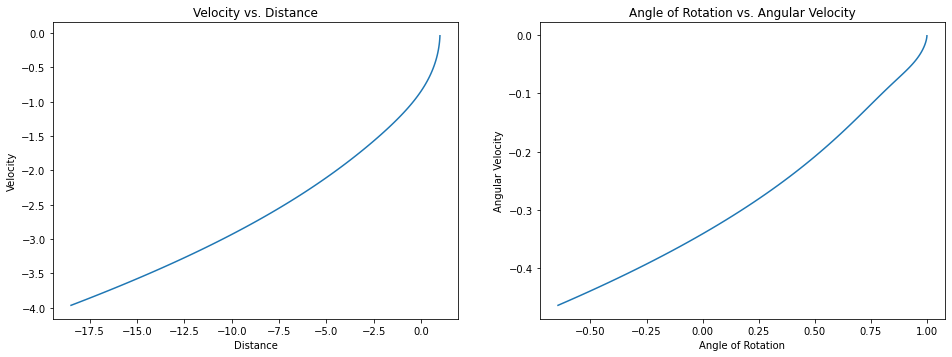

[2] loss: 106.1046


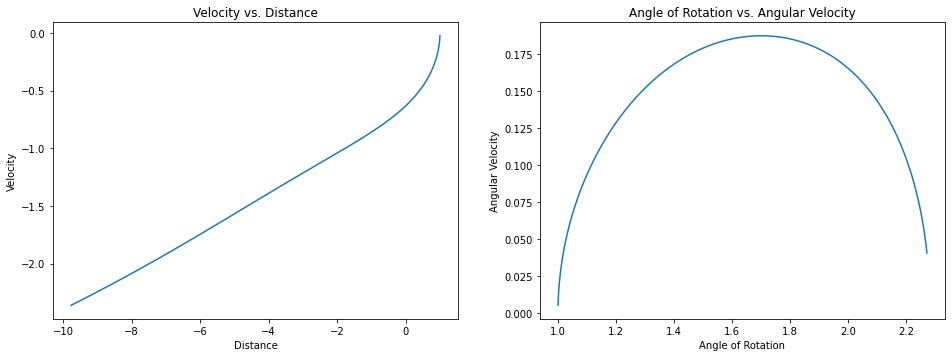

[3] loss: 54.4445


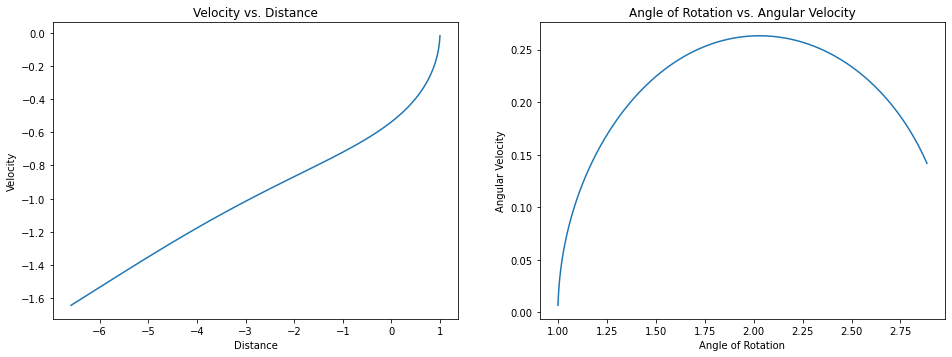

[4] loss: 32.2048


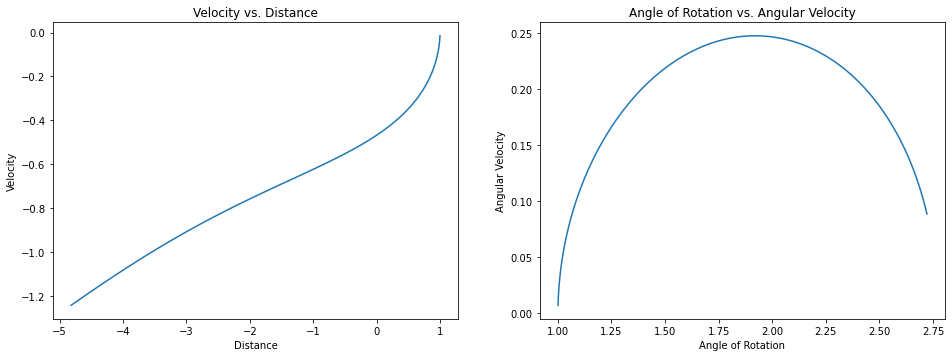

[5] loss: 20.5831


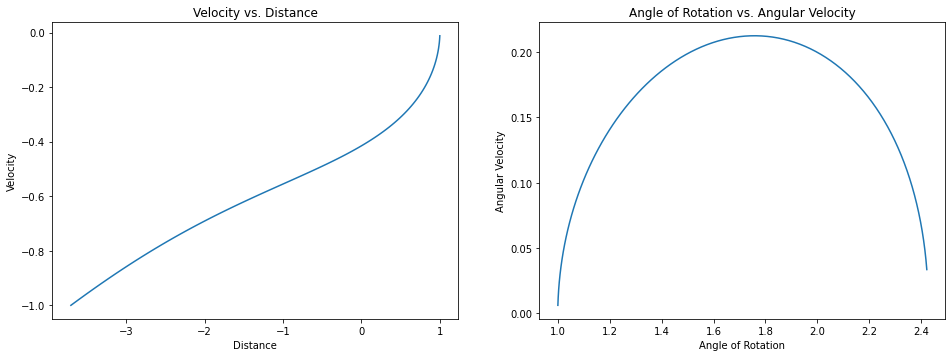

[6] loss: 13.6094


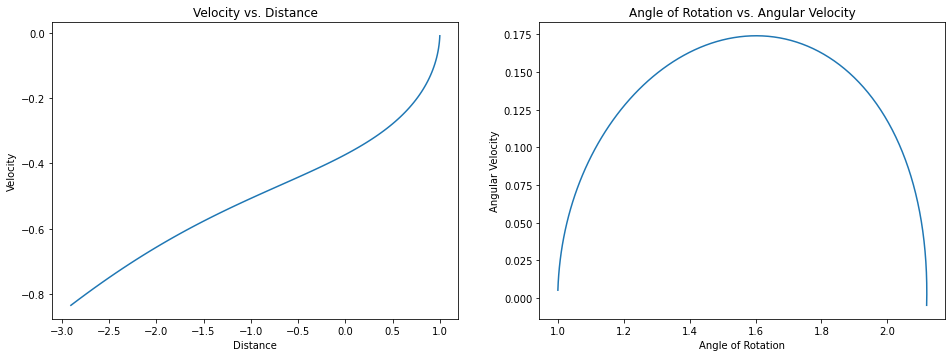

[7] loss: 9.0360


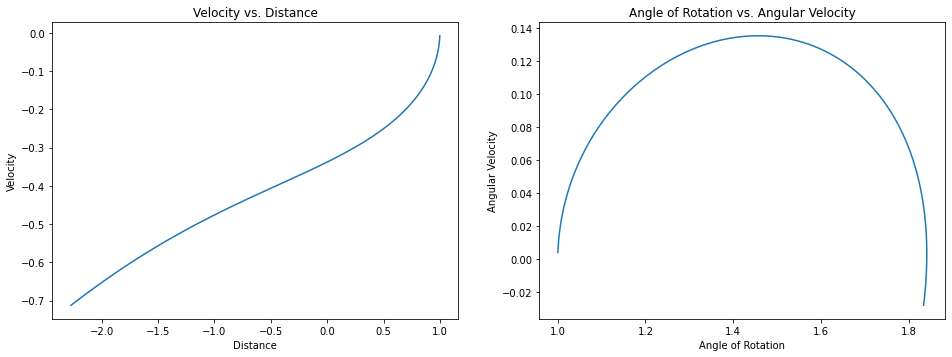

[8] loss: 5.8573


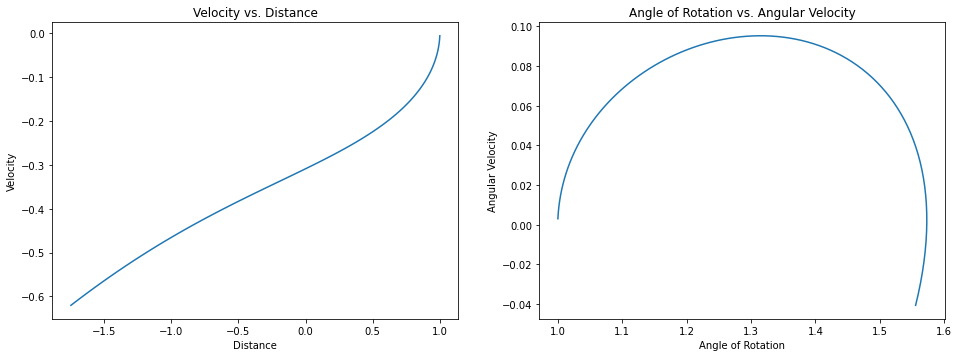

[9] loss: 3.5678


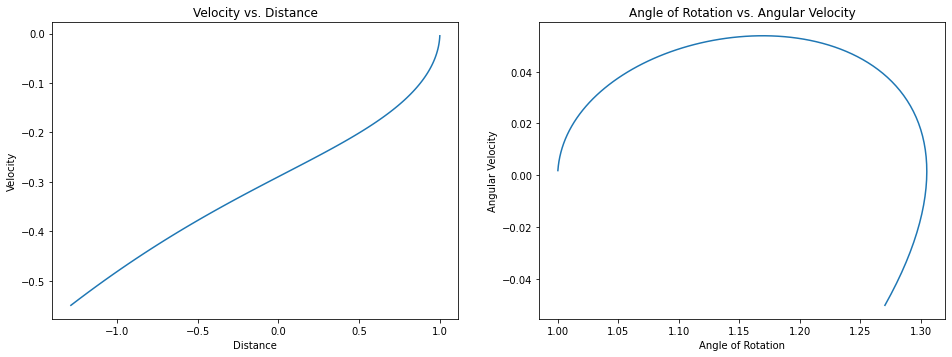

[10] loss: 2.0326


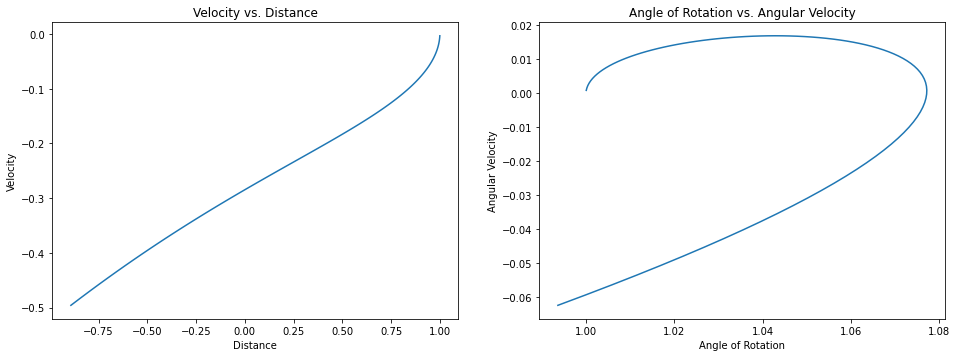

[11] loss: 1.1813


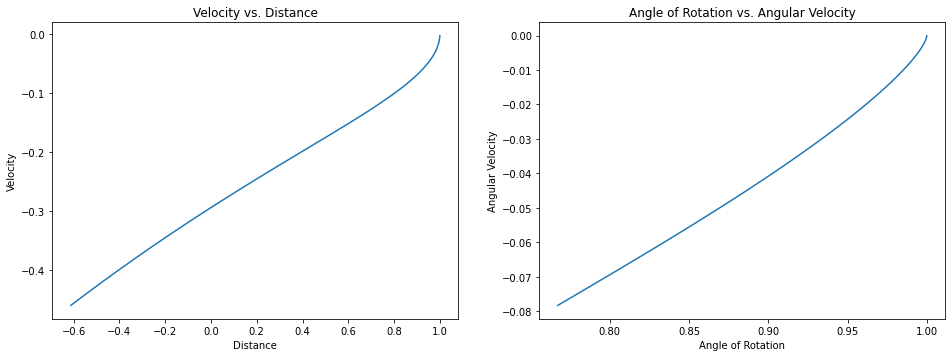

[12] loss: 0.7400


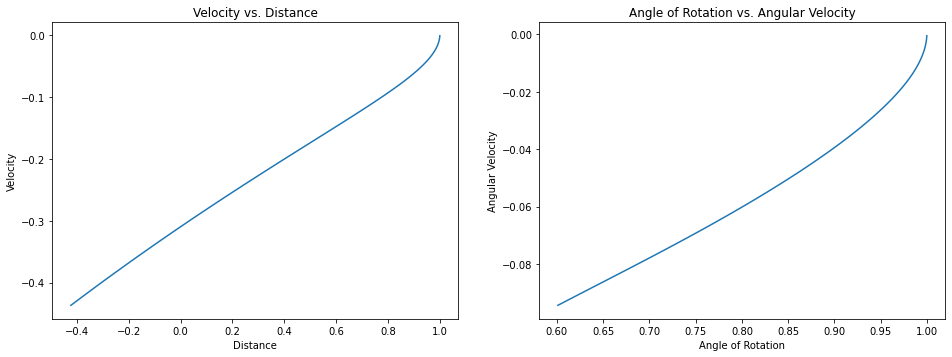

[13] loss: 0.5040


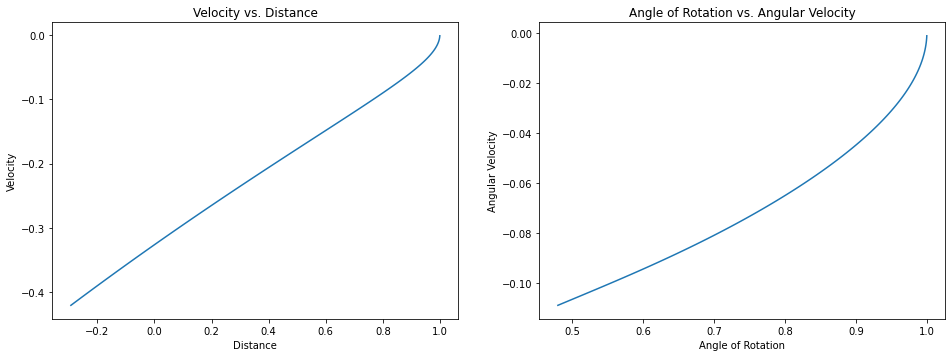

[14] loss: 0.3699


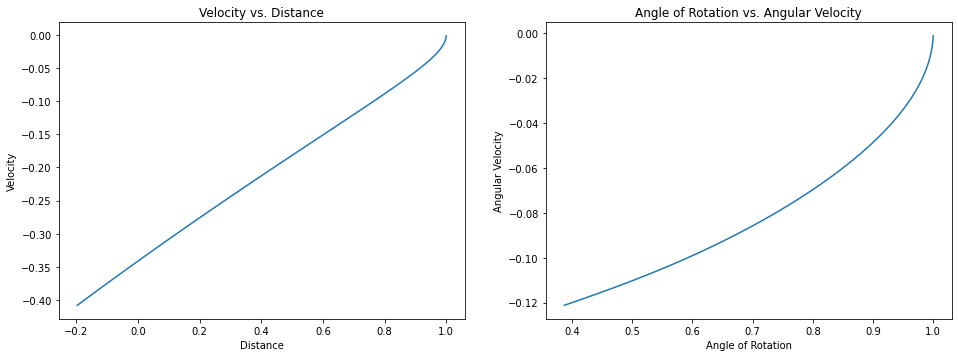

[15] loss: 0.2905


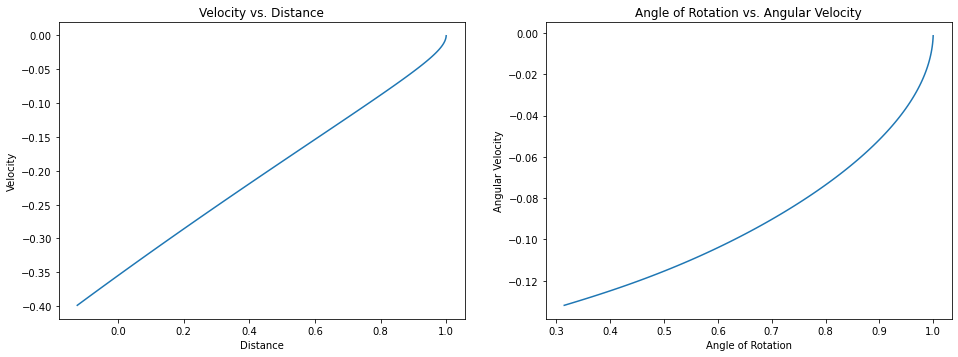

[16] loss: 0.2434


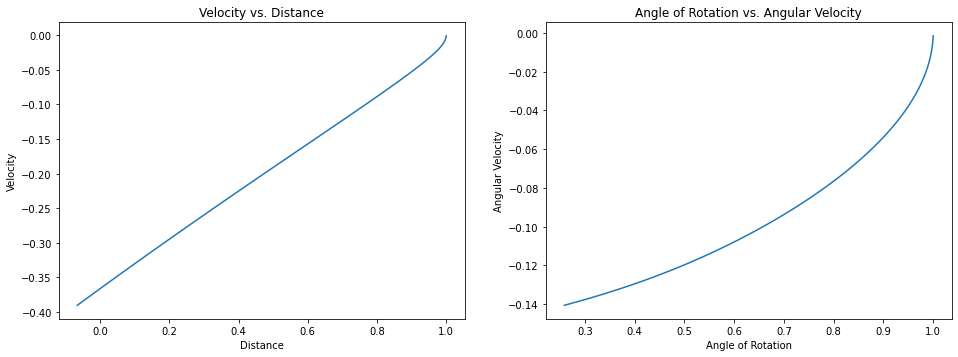

[17] loss: 0.2162


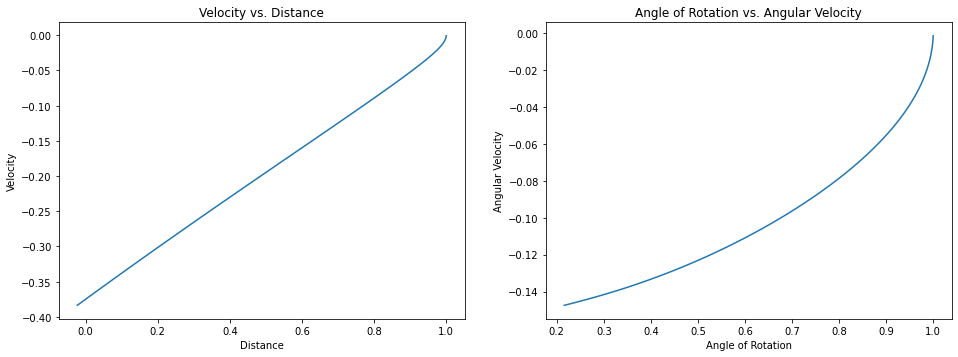

[18] loss: 0.1999


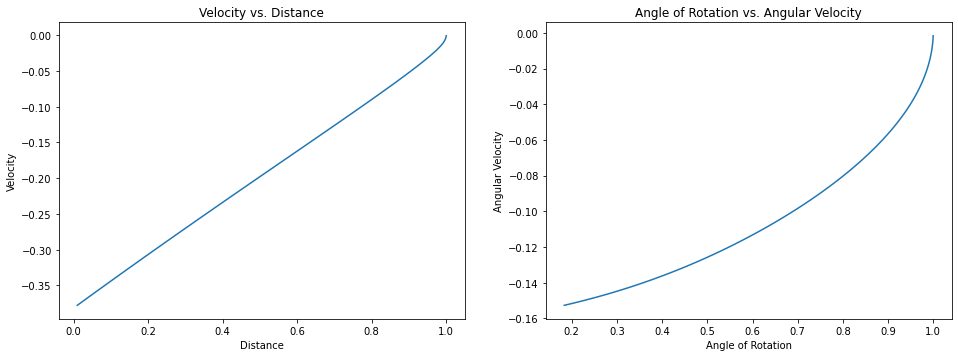

[19] loss: 0.1901


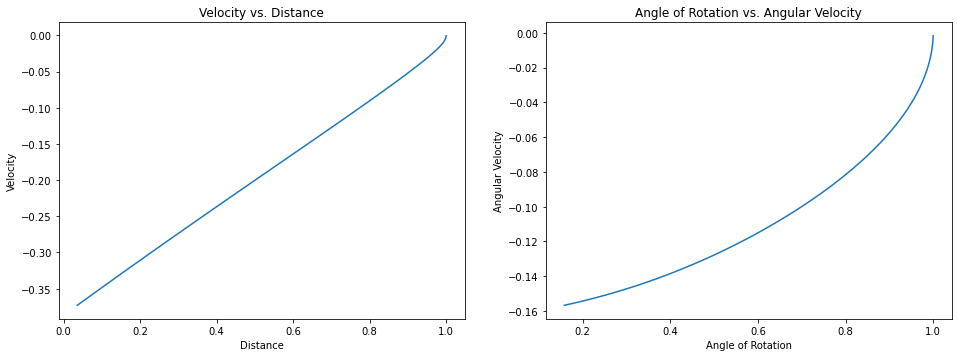

[20] loss: 0.1838


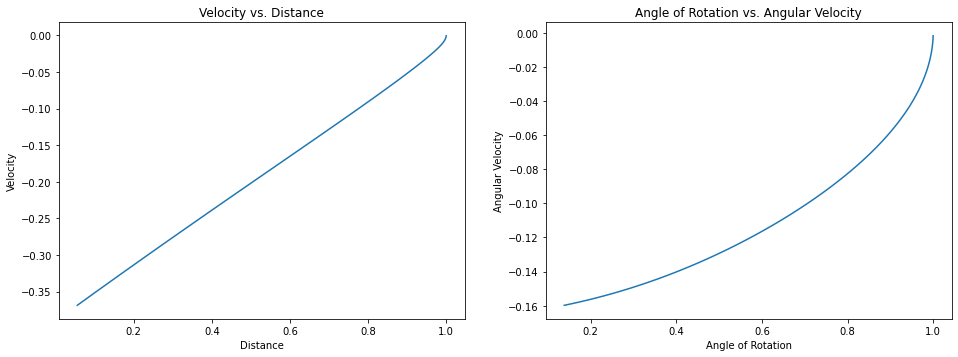

[21] loss: 0.1796


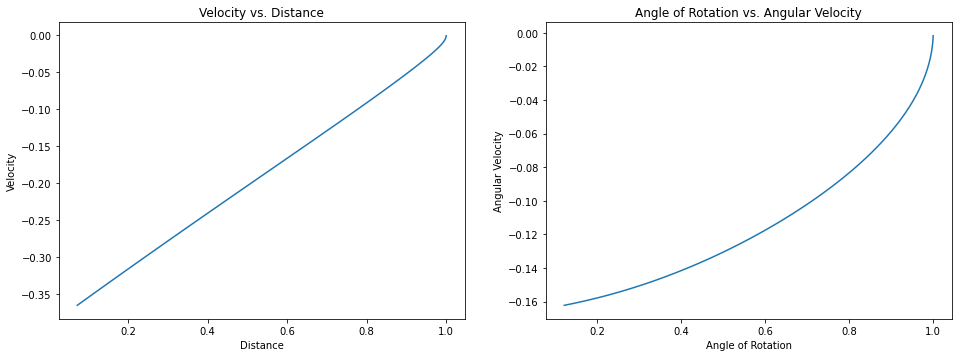

[22] loss: 0.1767


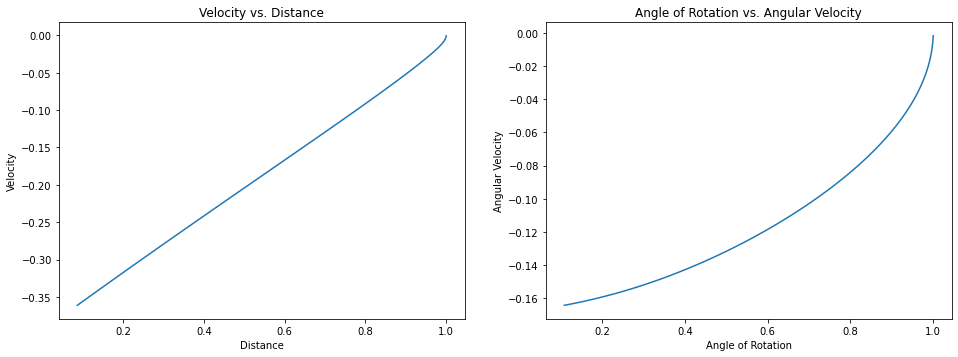

[23] loss: 0.1743


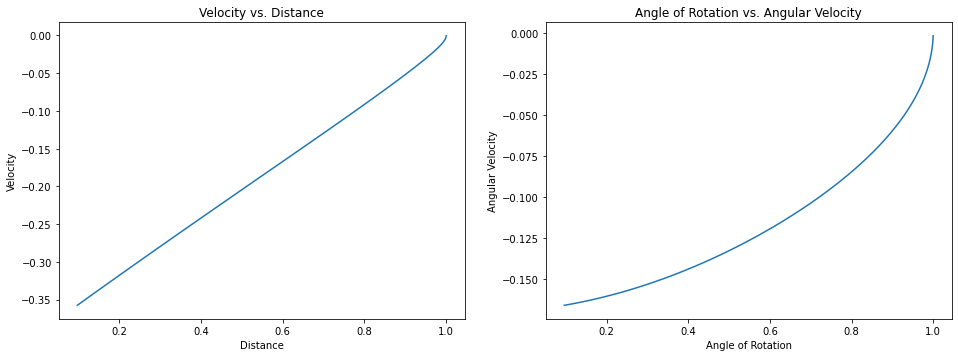

[24] loss: 0.1722


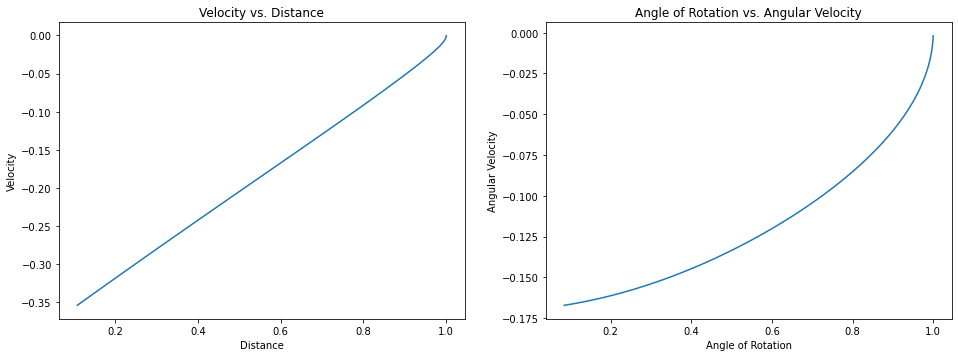

[25] loss: 0.1700


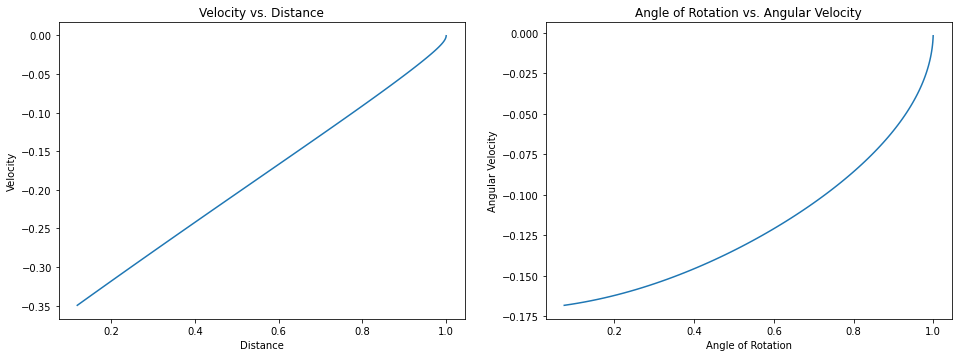

[26] loss: 0.1675


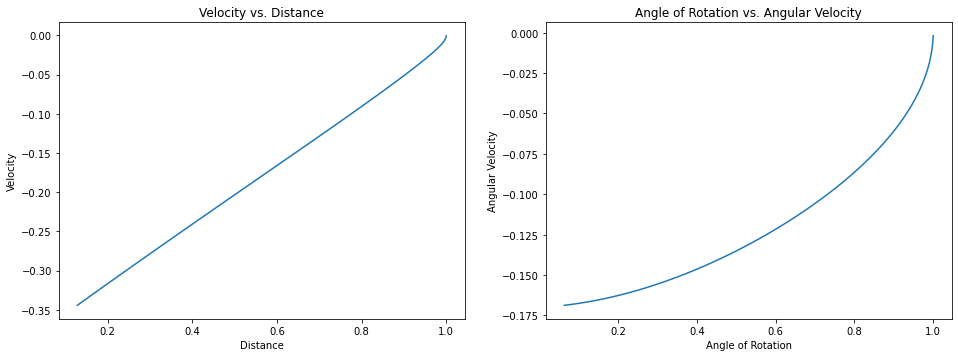

[27] loss: 0.1640


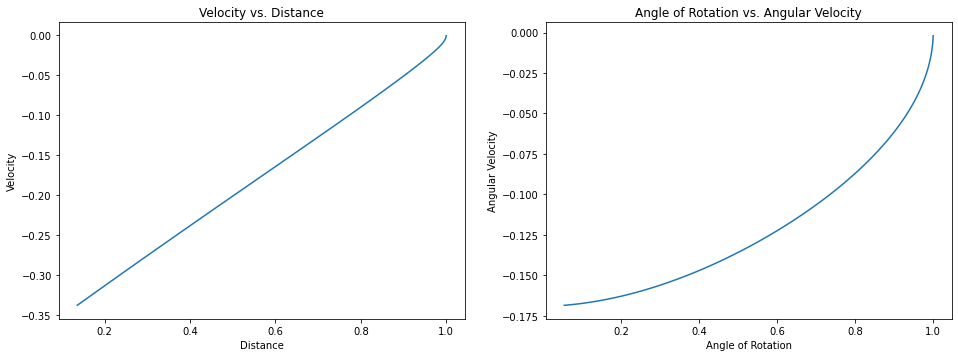

[28] loss: 0.1575


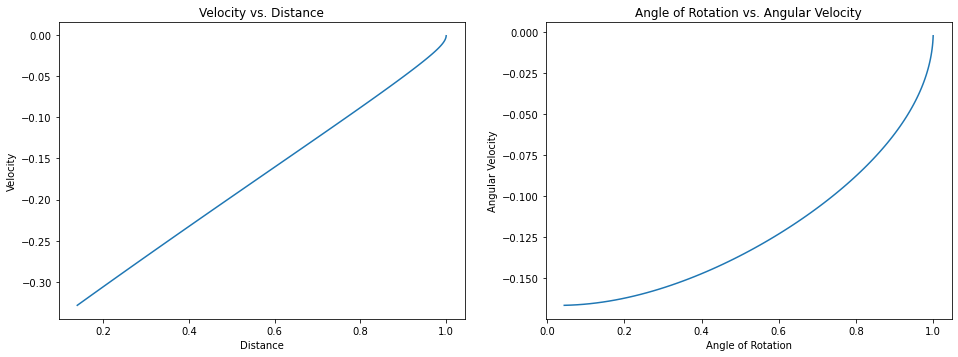

[29] loss: 0.1133


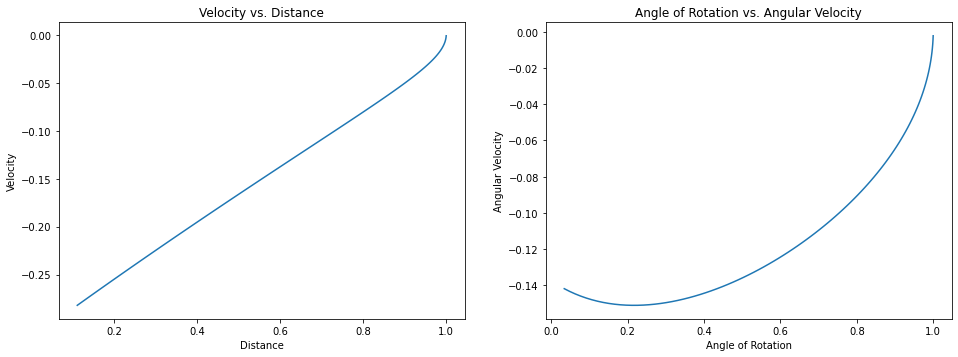

[30] loss: 0.0815


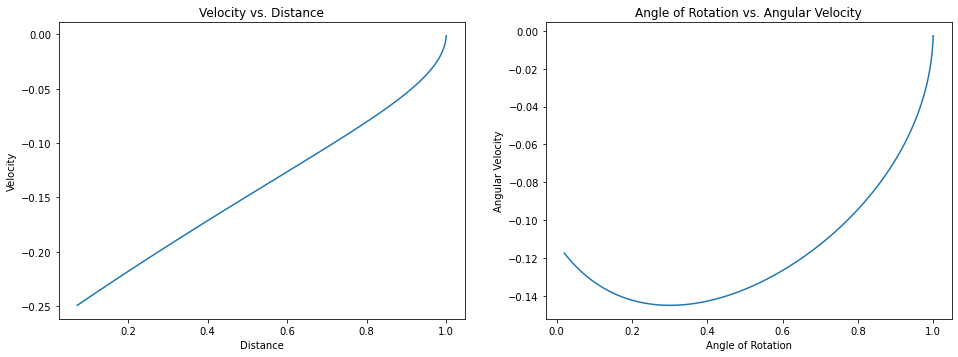

[31] loss: 0.0567


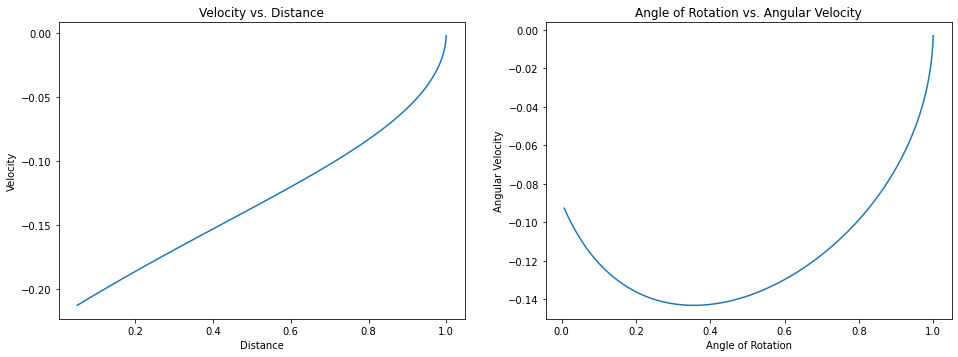

[32] loss: 0.0382


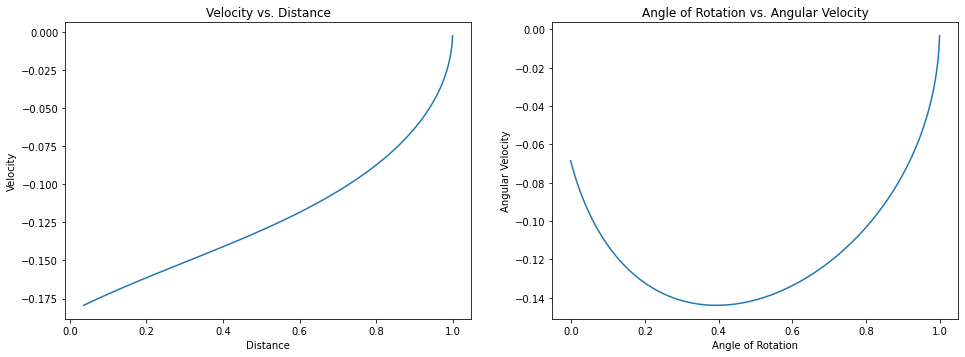

[33] loss: 0.0254


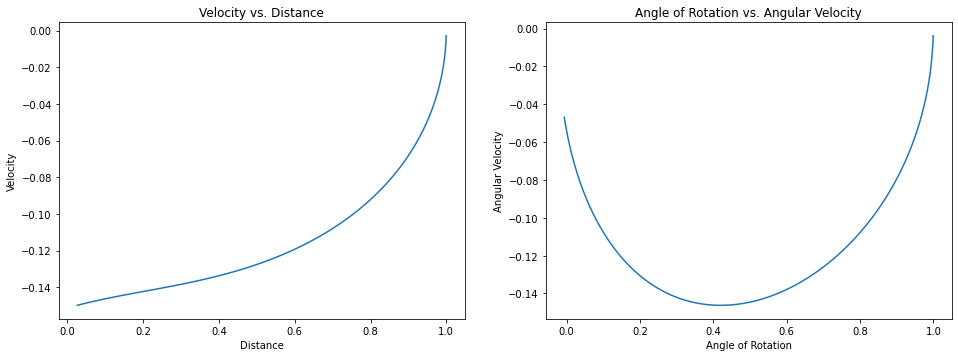

[34] loss: 0.0171


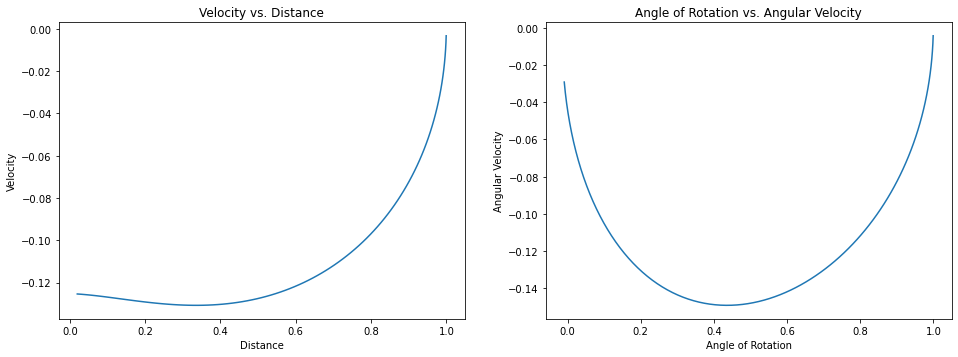

[35] loss: 0.0116


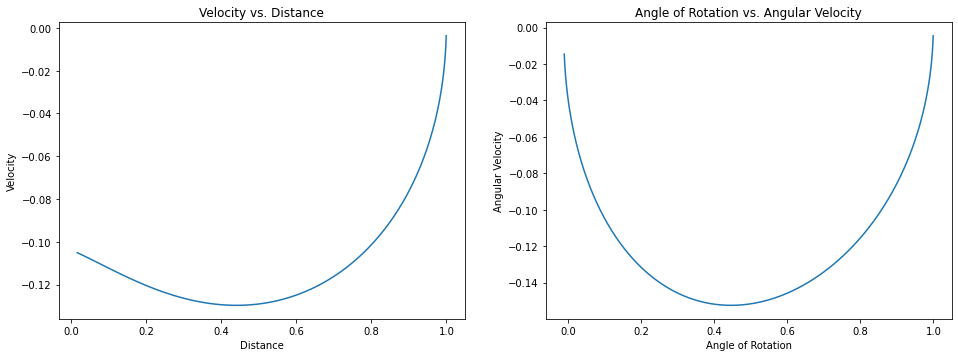

[36] loss: 0.0082


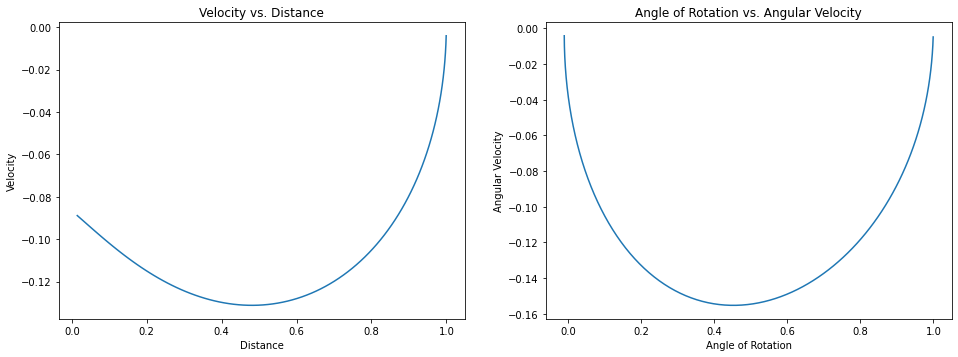

[37] loss: 0.0059


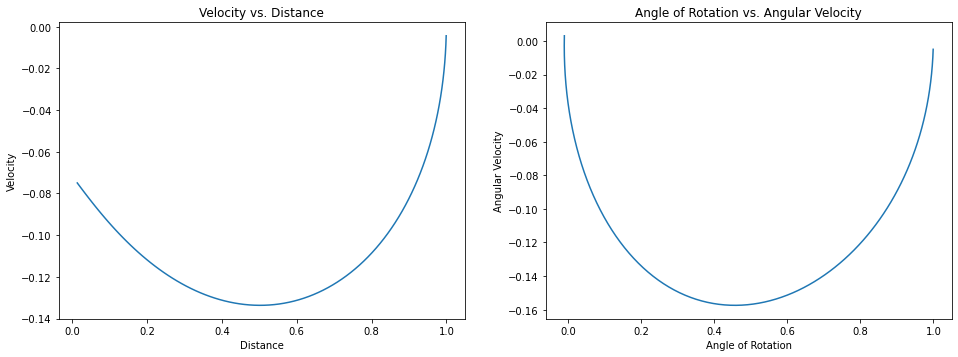

[38] loss: 0.0042


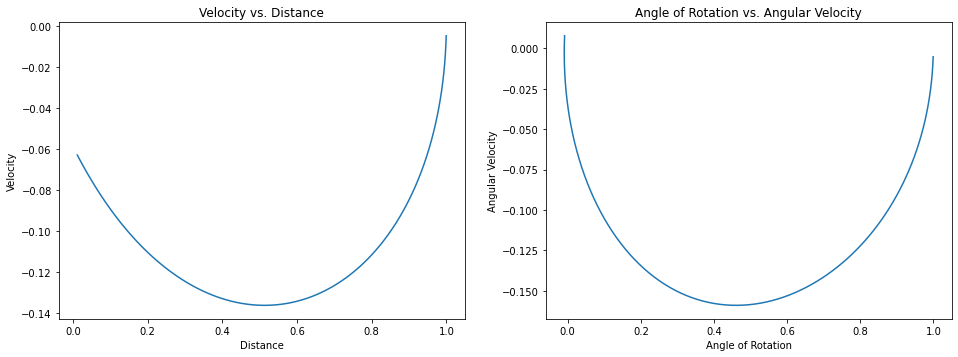

[39] loss: 0.0031


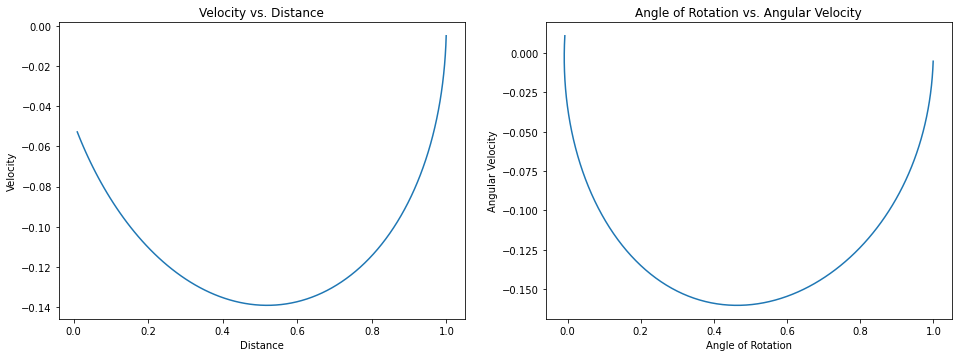

[40] loss: 0.0022


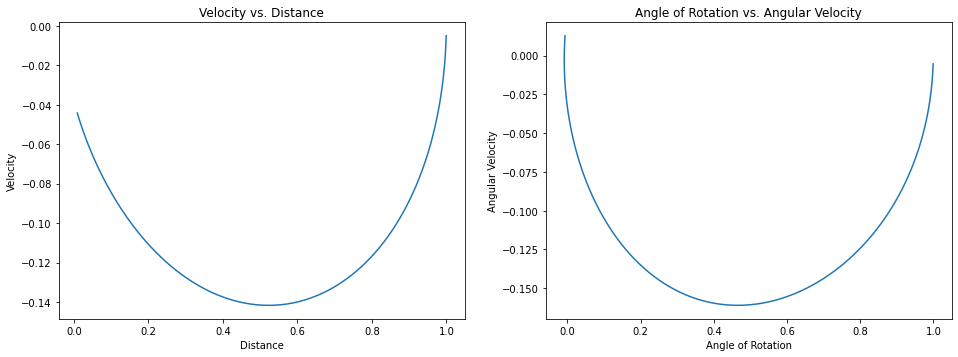

[41] loss: 0.0017


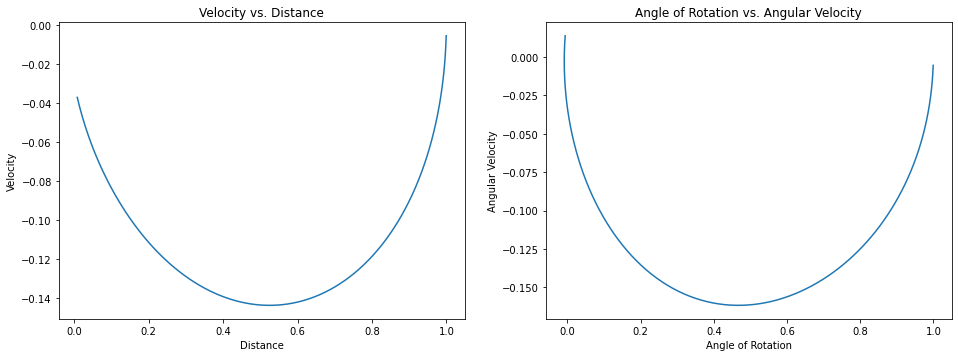

[42] loss: 0.0012


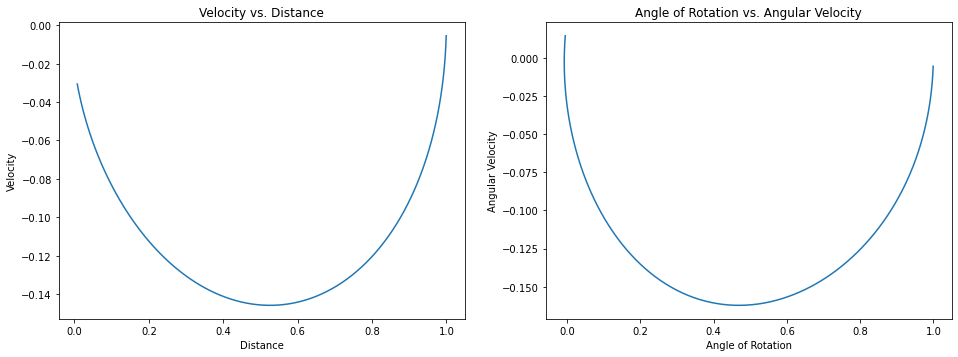

[43] loss: 0.0008


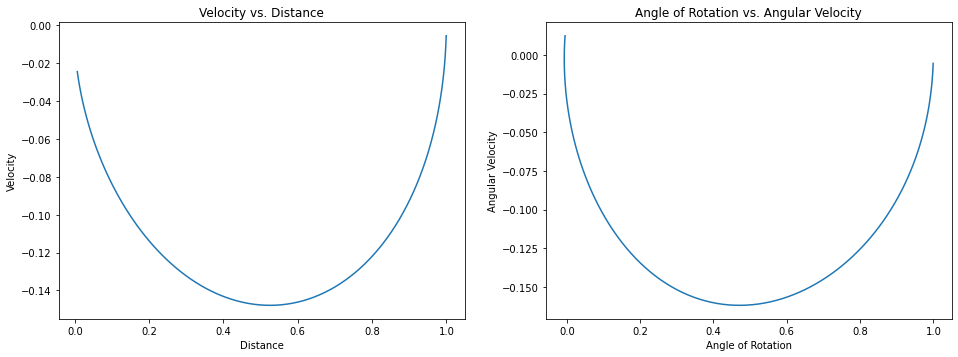

[44] loss: 0.0005


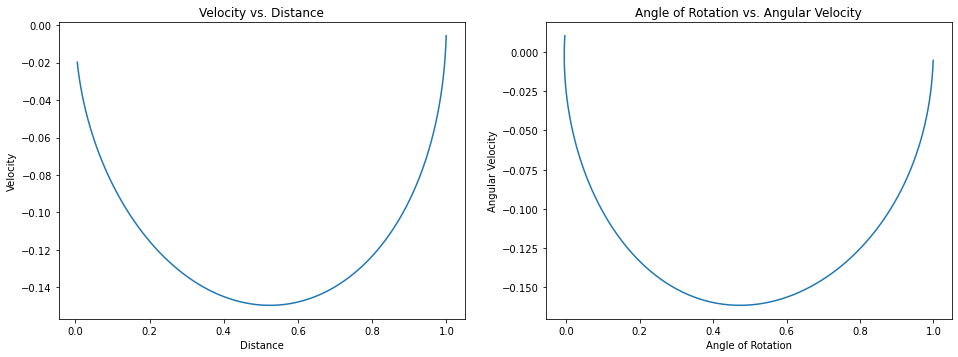

[45] loss: 0.0004


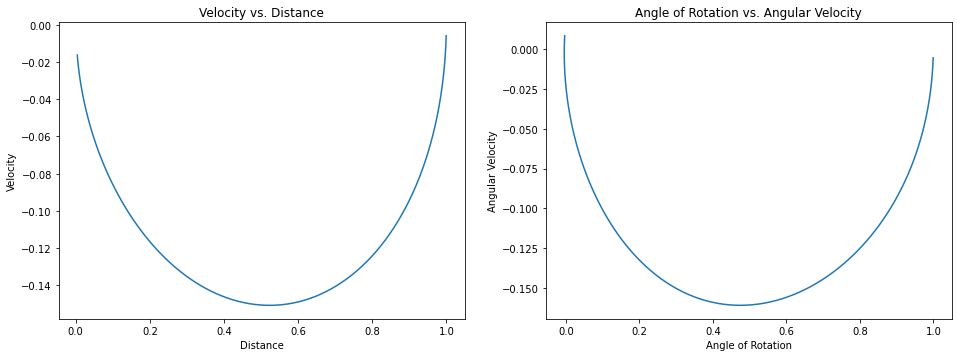

[46] loss: 0.0002


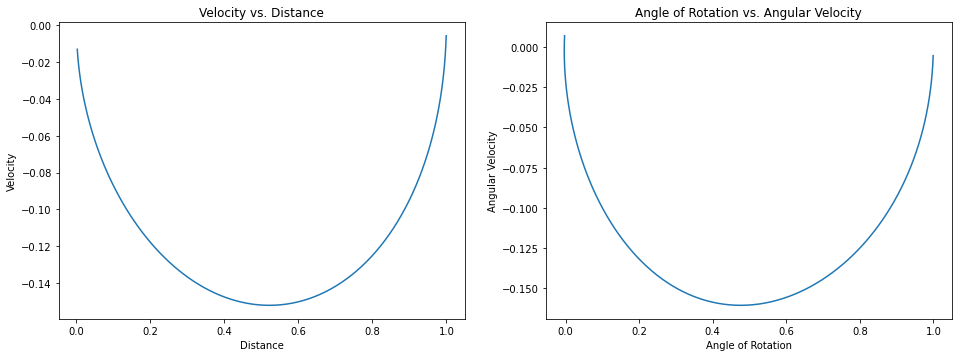

[47] loss: 0.0002


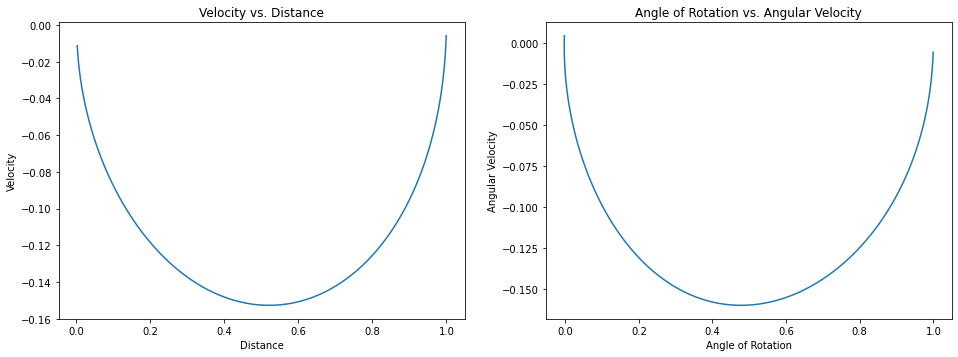

[48] loss: 0.0001


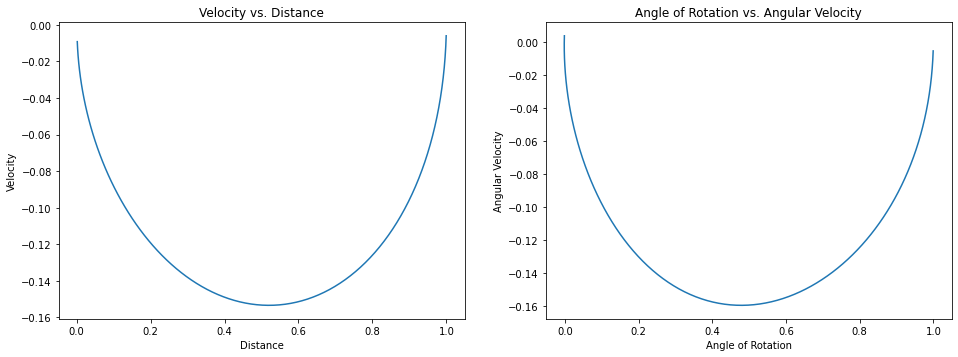

[49] loss: 0.0001


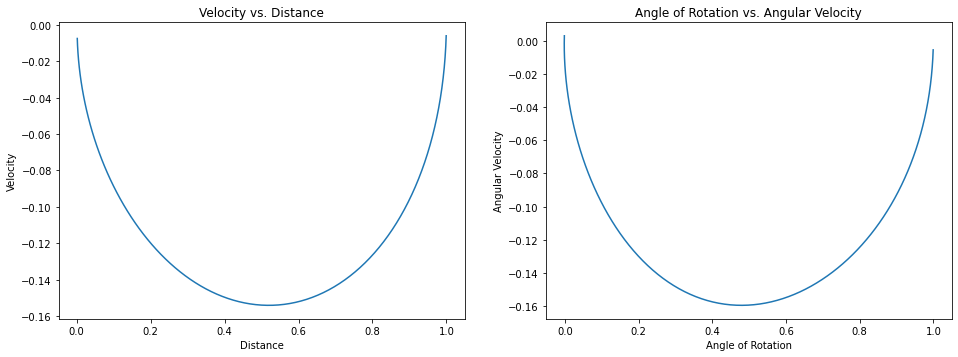

[50] loss: 0.0000


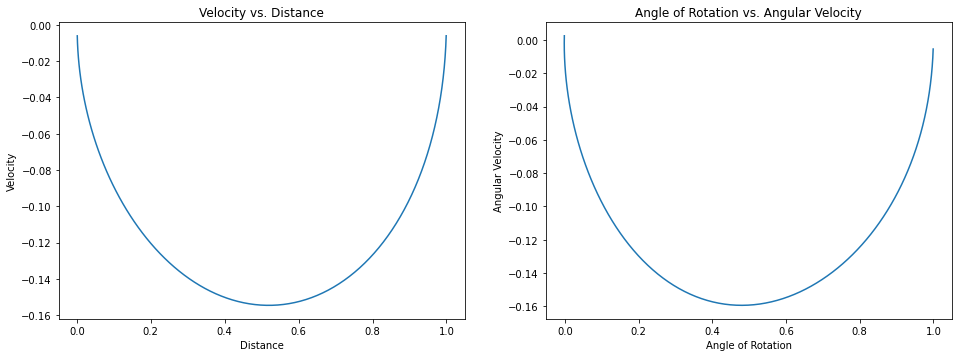

[51] loss: 0.0000


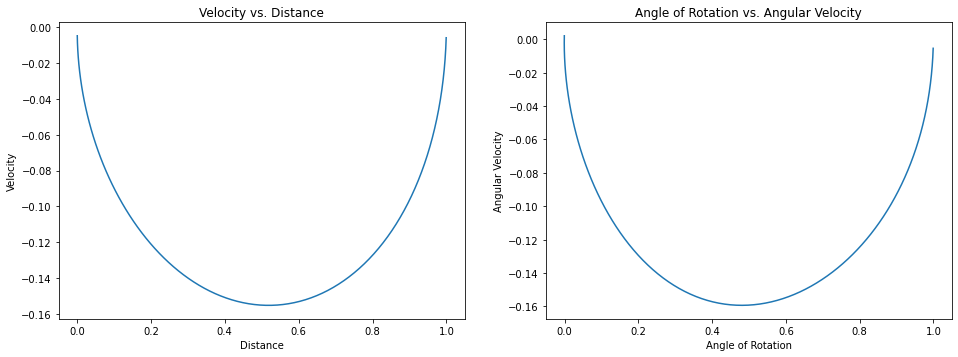

[52] loss: 0.0000


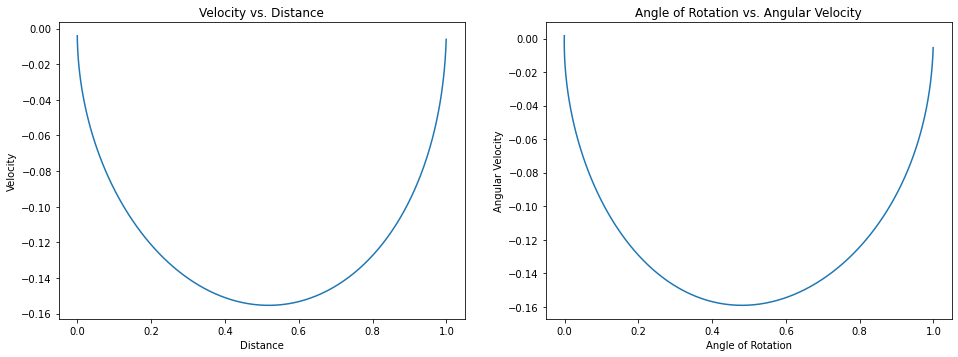

[53] loss: 0.0000


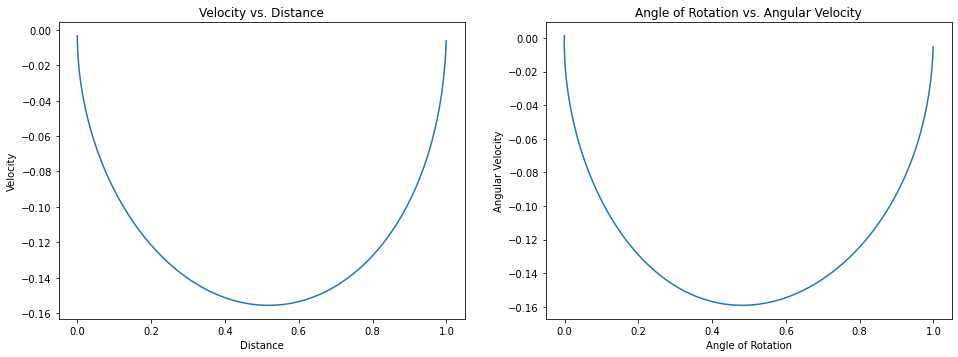

[54] loss: 0.0000


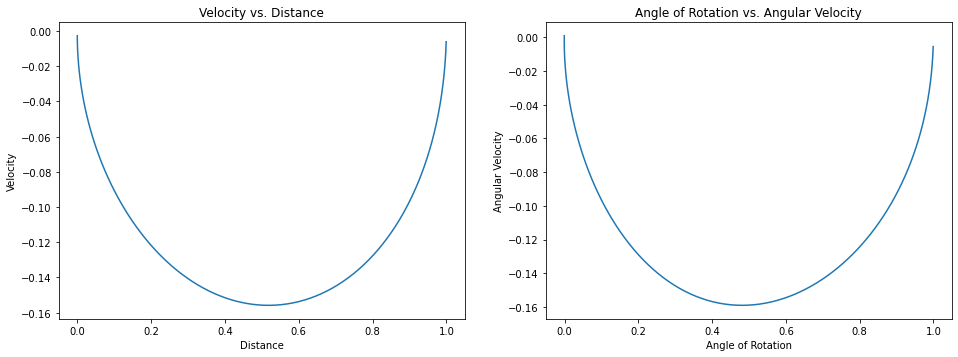

[55] loss: 0.0000


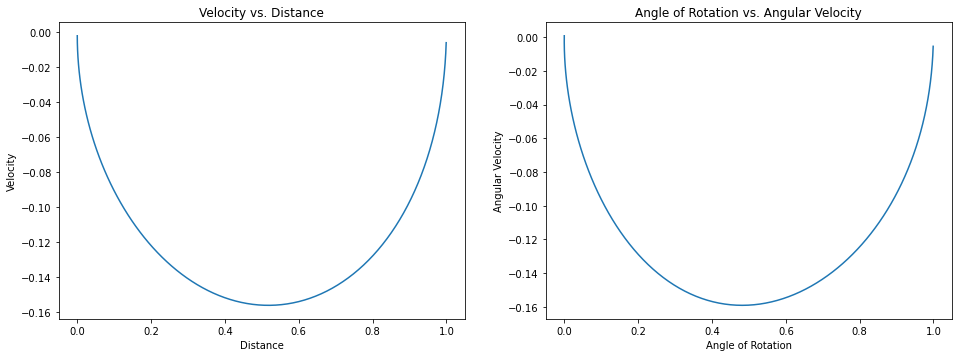

[56] loss: 0.0000


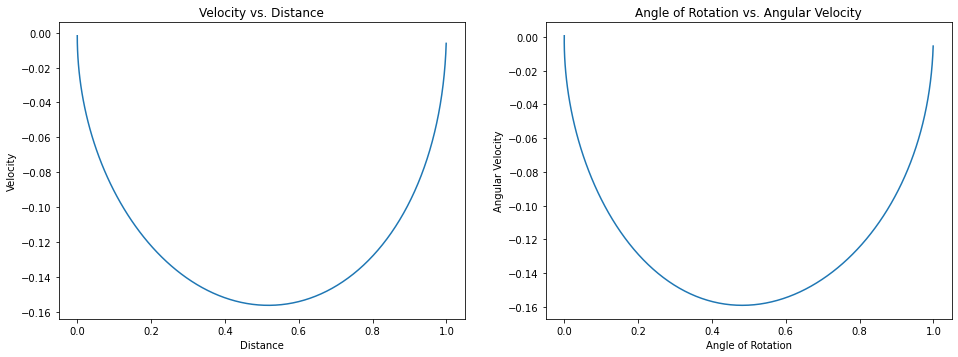

[57] loss: 0.0000


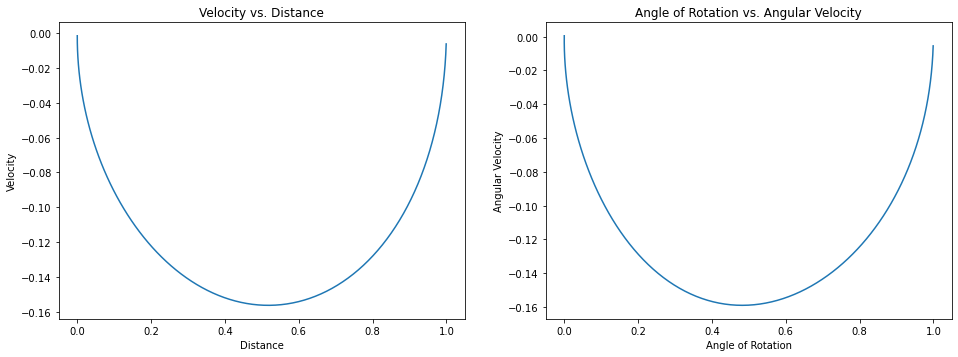

[58] loss: 0.0000


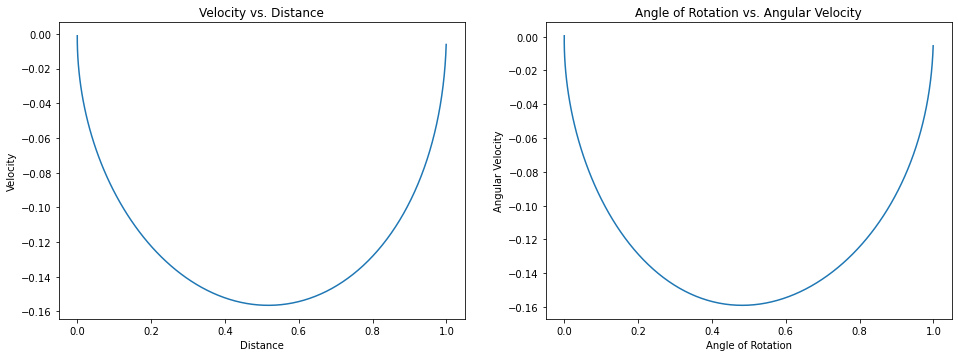

[59] loss: 0.0000


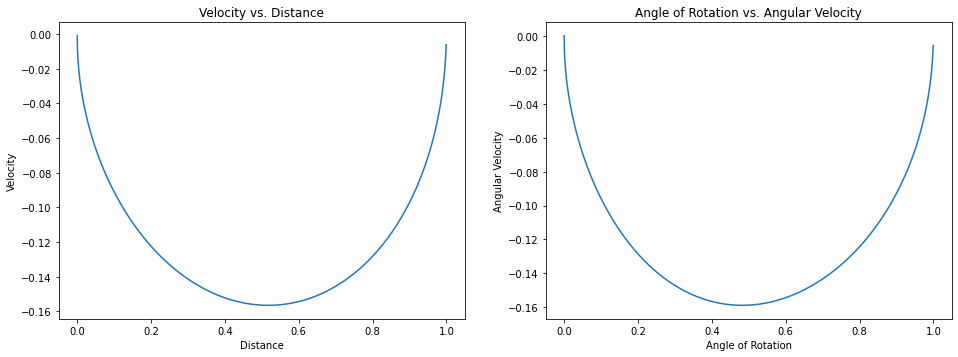

[60] loss: 0.0000


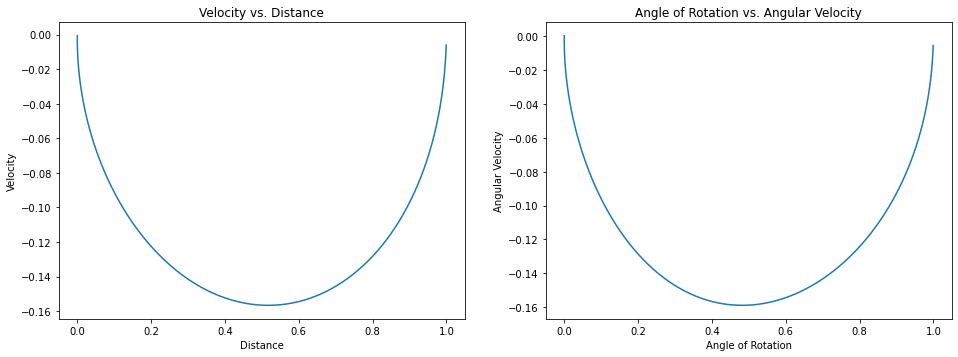

In [1]:
#Overhead

import logging
import math
import random
import numpy as np
import time
import torch as t
import torch.nn as nn
from torch import optim
from torch.nn import utils
import matplotlib.pyplot as plt

logger = logging.getLogger(__name__)

# environment parameters

FRAME_TIME = 0.1  # time interval
GRAVITY_ACCEL = 0.12  # gravity constant
BOOST_ACCEL = 1  # thrust constant
ROTATION_ACCEL = 0.5  # rotation constant (rotation of rocket w.r.t. to vertical)
SIDE_THRUST = 1 # side thrust constant

# # the following parameters are not being used in the sample code
# PLATFORM_WIDTH = 0.25  # landing platform width
# PLATFORM_HEIGHT = 0.06  # landing platform height

# define system dynamics
# Notes: 
# 0. You only need to modify the "forward" function
# 1. All variables in "forward" need to be PyTorch tensors.
# 2. All math operations in "forward" has to be differentiable, e.g., default PyTorch functions.
# 3. Do not use inplace operations, e.g., x += 1. Please see the following section for an example that does not work.

class Dynamics(nn.Module):

    def __init__(self):
        super(Dynamics, self).__init__()

    @staticmethod
    def forward(state, action):

        """
        action: thrust or no thrust
        state[0] = y
        state[1] = y_dot
        state[2] = ang_of_rotation
        state[3] = ang_velocity
        """
        """
        Drag force = 0.5 * Cd * density * (velocity^2) * A
        Cd = drag coefficient = 0.75
        density = density of gas (Air) 1.229kg/cu.m.
        velocity = delta_state (assuming velocity as 58 m/s)
        A  = cross sectional area = (pi * 3.8 * 3.8)
        Mass of rocket(assuming weight of falcon 9) = 54400 kg
        Drag Force = 0.5 * 0.75 * 1.229 * (58^2) * 45.3646 = 70332.5273
        Decelaration due to drag = (Drag Force - Mass of rocket)/(Mass of rocket) = 0.2929
        Resultant acceleration = Thrust + decelaration due to drag = 1 + 0.2929 = 0.7729 
        """
        DRAG_DECEL = 0.2929
        RES_ACCEL = BOOST_ACCEL + DRAG_DECEL
        # Apply gravity
        # Note: Here gravity is used to change velocity which is the second element of the state vector
        # Normally, we would do x[1] = x[1] + gravity * delta_time
        # but this is not allowed in PyTorch since it overwrites one variable (x[1]) that is part of the computational graph to be differentiated.
        # Therefore, I define a tensor dx = [0., gravity * delta_time], and do x = x + dx. This is allowed... 
        delta_state_gravity = t.tensor([0., GRAVITY_ACCEL * FRAME_TIME, 0., 0.]) # Modified for rotation

        # Thrust
        # Note: Same reason as above. Need a 4-by-1 tensor.
        delta_state = RES_ACCEL * FRAME_TIME * t.tensor([0., -1., 0., 0.]) * action[1] # Modified

        # Update rotation of rocket w.r.t. to vertical
        # Note: Same reason as above. Need a 4-by-1 tensor.
        delta_rotation_ang = ROTATION_ACCEL * FRAME_TIME * t.tensor([0., 0., 0., 1.]) # Modified

        # Update side thrust
        # Note: Same reason as above. Need a 4-by-1 tensor.
        delta_ang_accel = SIDE_THRUST * FRAME_TIME * t.tensor([0., 0., 0., -1.]) * action[0] # Modified
 
        # Update velocity
        state = state + delta_state + delta_state_gravity + delta_rotation_ang + delta_ang_accel # Modified

        # Update state
        # Note: Same as above. Use operators on matrices/tensors as much as possible. Do not use element-wise operators as they are considered inplace.
        step_mat = t.tensor([[1., FRAME_TIME, 0., 0.],  # Modified
                            [0., 1., 0., 0.],
                            [0., 0., 1., FRAME_TIME],
                            [0., 0., 0., 1.]])
        
        state = t.matmul(step_mat, state)

        return state

# a deterministic controller
# Note:
# 0. You only need to change the network architecture in "__init__"
# 1. nn.Sigmoid outputs values from 0 to 1, nn.Tanh from -1 to 1
# 2. You have all the freedom to make the network wider (by increasing "dim_hidden") or deeper (by adding more lines to nn.Sequential)
# 3. Always start with something simple

class Controller(nn.Module):

    def __init__(self, dim_input, dim_hidden, dim_output):
        """
        dim_input: # of system states
        dim_output: # of actions
        dim_hidden: up to you
        """
        super(Controller, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(dim_input, dim_hidden),
            nn.Tanh(),
            nn.Linear(dim_hidden, dim_output),
            nn.Sigmoid()
        )

    def forward(self, state):
        action = self.network(state)
        return action

# the simulator that rolls out x(1), x(2), ..., x(T)
# Note:
# 0. Need to change "initialize_state" to optimize the controller over a distribution of initial states
# 1. self.action_trajectory and self.state_trajectory stores the action and state trajectories along time

class Simulation(nn.Module):

    def __init__(self, controller, dynamics, T):
        super(Simulation, self).__init__()
        self.state = self.initialize_state()
        self.controller = controller
        self.dynamics = dynamics
        self.T = T
        self.action_trajectory = []
        self.state_trajectory = []

    def forward(self, state):
        self.action_trajectory = []
        self.state_trajectory = []
        for _ in range(T):
            action = self.controller.forward(state)
            state = self.dynamics.forward(state, action)
            self.action_trajectory.append(action)
            self.state_trajectory.append(state)
        return self.error(state)

    @staticmethod
    def initialize_state():
        state = [1., 0., 1., 0.]  # TODO: need batch of initial states (Modified)
        return t.tensor(state, requires_grad=False).float()

    def error(self, state):
        return state[0]**2 + state[1]**2 + state[2]**2 + state[3]**2 # Modified

# set up the optimizer
# Note:
# 0. LBFGS is a good choice if you don't have a large batch size (i.e., a lot of initial states to consider simultaneously)
# 1. You can also try SGD and other momentum-based methods implemented in PyTorch
# 2. You will need to customize "visualize"
# 3. loss.backward is where the gradient is calculated (d_loss/d_variables)
# 4. self.optimizer.step(closure) is where gradient descent is done

class Optimize:
    def __init__(self, simulation):
        self.simulation = simulation
        self.parameters = simulation.controller.parameters()
        self.optimizer = optim.LBFGS(self.parameters, lr=0.01) # Solved using LBFGS

    def step(self):
        def closure():
            loss = self.simulation(self.simulation.state)
            self.optimizer.zero_grad()
            loss.backward()
            return loss
        self.optimizer.step(closure)
        return closure()
    
    def train(self, epochs):
        for epoch in range(epochs):
            loss = self.step()
            print('[%d] loss: %.4f' % (epoch + 1, loss))
            self.visualize()

    def visualize(self):
        data = np.array([self.simulation.state_trajectory[i].detach().numpy() for i in range(self.simulation.T)])
        x = data[:, 0]
        y = data[:, 1]
        ang_of_rotation = data[:, 2]
        ang_velocity = data[:, 3]
        plt.figure(figsize=(16,12))

        plt.subplot(2,2,1)
        plt.plot(x, y)
        plt.xlabel("Distance")
        plt.ylabel("Velocity")
        plt.title("Velocity vs. Distance") #Plot of velocity vs distance

        plt.subplot(2,2,2)
        plt.plot(ang_of_rotation, ang_velocity)
        plt.xlabel("Angle of Rotation")
        plt.ylabel("Angular Velocity")
        plt.title("Angle of Rotation vs. Angular Velocity") #Plot of angle of rotation vs. angular Velocity
        plt.show()

# Now it's time to run the code!

T = 100  # number of time steps
dim_input = 4  # state space dimensions (Modified)
dim_hidden = 8  # latent dimensions (Modified)
dim_output = 2  # action space dimensions (Modified)
d = Dynamics()  # define dynamics
c = Controller(dim_input, dim_hidden, dim_output)  # define controller
s = Simulation(c, d, T)  # define simulation
o = Optimize(s)  # define optimizer
o.train(60)  # solve the optimization problem